# Spliting channels

In [2]:
from wfield import *
import tifffile
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import re
import shutil

In [6]:
def list_scans(data_folder, keyword):
    # Find folders containing the keyword
    scan_folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

    # Print list of found folders
    print("Folders containing '{}' keyword:")
    for i, folder in enumerate(scan_folders):
        print(f"{i + 1}. {folder}")

    # Prompt user to choose a folder
    while True:
        choice = input("Enter the number of the scan you want to choose: ")
        if choice.isdigit() and 1 <= int(choice) <= len(scan_folders):
            chosen_folder = scan_folders[int(choice) - 1]
            break
        else:
            print("Invalid input. Please enter a valid number.")
    print("Selected",chosen_folder)
    # Return the path to the chosen folder
    return os.path.join(data_folder, chosen_folder), chosen_folder


In [7]:
def save_video_from_array(array, filename_prefix, folder, num_channels):
    n_frames, *shape = array.shape
    height, width = shape[-2:]

    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    if len(shape) == 2:  # Single channel
        channels_to_save = 1
    elif len(shape) == 3:  # Multiple channels
        channels_to_save = min(num_channels, shape[0])
    else:
        raise ValueError("Invalid array shape.")

    # Iterate over each channel
    for channel_idx in range(channels_to_save):
        # Create VideoWriter object
        filename = os.path.join(folder, f"{filename_prefix}_channel{channel_idx}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change codec to MP4V for MP4 format
        out = cv2.VideoWriter(filename, fourcc, 25.0, (width, height))

        # Iterate over each frame
        for frame_idx in range(n_frames):
            # Extract channel if multiple channels, else use array directly
            channel_array = array[frame_idx, channel_idx] if len(shape) == 3 else array[frame_idx]

            # Normalize pixel values to 0-255 range
            channel_array = (channel_array - np.min(channel_array)) / (np.max(channel_array) - np.min(channel_array)) * 255

            # Convert to uint8
            frame = channel_array.astype(np.uint8)

            # Apply colormap if needed (e.g., for grayscale images)
            frame = cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS)

            # Write frame to video file
            out.write(frame)

        # Release VideoWriter object
        out.release()

    print("Videos saved successfully.")

In [8]:
data_folder = r'/datajoint-data/data/aeltona/'
# tif_file_path = pjoin(data_folder, 'scan9FN2ANVG_Oddball_AA_ROS-1706_2025_MMStack_Default.ome.tif')
# localdisk = r'C:\datatemp'
localdisk, scan_idx = list_scans(data_folder,"AA")



Folders containing '{}' keyword:
1. Habituation_AA_WEZ-8950_2024-04-16_scan9FNN1Y64_sess9FNN0LFP
2. Habituation_AA_WEZ-8948_2024-04-17_scan9FNNP1N7_sess9FNNO3Z1
3. Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG
4. AA_ROS-1688_2024_01_27_scan000WQU9_sess000EAEIO
5. Habituation_AA_WEZ-8950_2024-04-18_scan9FNO8CLT_sess9FNO8CLT
6. Habituation_AA_WEZ-8950_2024-04-17_scan9FNNO3Z1_sess9FNNO3Z1
7. AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG
8. Habituation_AA_WEZ-8950_2024-04-16_scan9FNN1YXK_sess9FNN1YXK
9. Habituation_AA_WEZ-8948_2024-04-18_scan9FNO99ZE_sess9FNO8CLT
10. AA_ROS-1688_2024_01_27_scan000EAEIO_sess000EAEIO
11. Habituation_AA_WEZ-8950_2024-04-16_scan9FNN2FX7_sess9FNN1YXK
12. Habituation_AA_WEZ-8948_2024-04-16_scan9FNN1M1R_sess9FNN0LFP
Selected AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG


In [16]:
tif_files = [f for f in os.listdir(localdisk) if f.endswith('.tif')]
try:
    dat_path = glob(pjoin(localdisk,'*.dat'))[0]
    print("Binaries file found")
    print("Loading...")
    dat = mmap_dat(dat_path)
    n_frames, h, w, n_channels = dat.shape
    
    dat = mmap_dat(dat_path, mode='r+', nframes=n_frames, shape=(2, h, w))
    print(f'Loaded {n_frames} frames with {h} x {w} (height x width)')


except:
    print("Binaries file not found")
    print("-----------------------")
    print("Concatenating TIF files...")
    print("-----------------------")
    tif_data_list = []
    for tif_file in sorted(tif_files):
        tif_file_path = os.path.join(localdisk, tif_file)
        tif_data = tifffile.imread(tif_file_path);
        tif_data_list.append(tif_data)
    concatenated_data = np.concatenate(tif_data_list, axis=0)
    print(concatenated_data.shape)
    # Splitting into violet and green channels
    violet_channel = concatenated_data[::2]  # Every second frame starting from the first
    green_channel = concatenated_data[1::2]  # Every second frame starting from the second

    # Ensure both channels have the same length (in case the number of frames is odd)
    if violet_channel.shape[0] > green_channel.shape[0]:
        violet_channel = violet_channel[:-1]
    h, w = green_channel.shape[1:]
    # print(h,w)
    merged_data = np.stack((violet_channel, green_channel), axis=1)
    n_frames = merged_data.shape[0]
    # print(n_frames)
    filename_parts = re.split(r'_|\.', tif_files[0])
    scan_info = '_'.join(filename_parts[0:4])  # Joining parts 1 to 4 with underscores
    frame_shape = f"{h}_{w}"
    filename = f"{scan_info}_{frame_shape}_2_uint16.dat"
    print(f"Saving file in {filename}")
    save_path = os.path.join(localdisk, filename)
    merged_data.astype(np.uint16).tofile(save_path)
    del merged_data


Binaries file found
Loading...
Loaded 8619 frames with 600 x 600 (height x width)


In [7]:
save_video_from_array(violet_channel, f"{scan_idx}_violet_uncorrected",localdisk,1)
save_video_from_array(green_channel, f"{scan_idx}_green_uncorrected",localdisk,1)

Videos saved successfully.
Videos saved successfully.


# Motion Correction

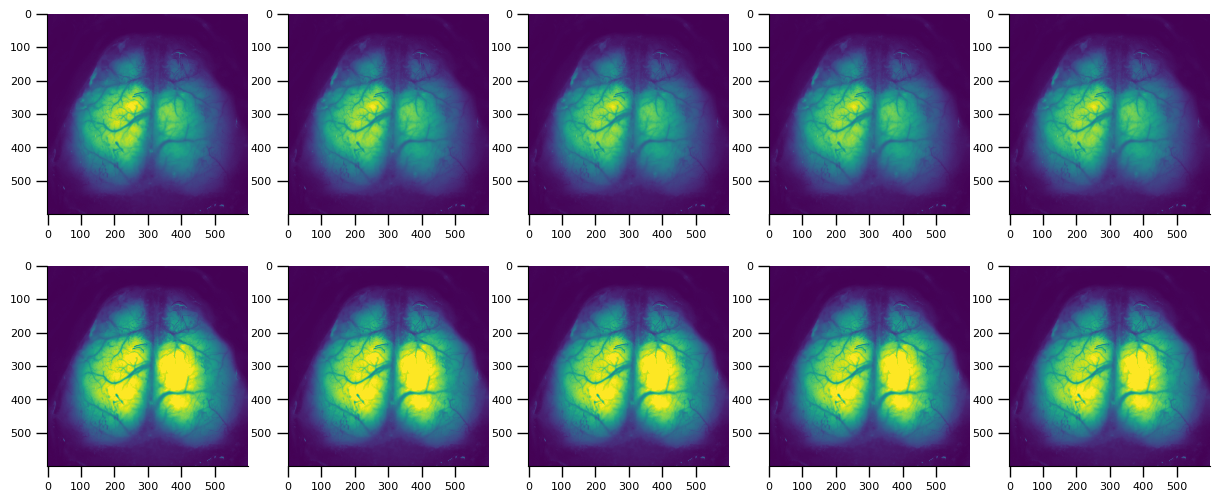

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

num_frames = 5;
for j in range(num_frames):
    axes[0, j].imshow(dat[j, 0, :, :])  # Violet channel, First 5 frames
    axes[1, j].imshow(dat[j, 1, :, :])  # Blue channel, First 5 frames

plt.show()

In [21]:
(yshifts,xshifts),rot = motion_correct(dat,chunksize=512,
                                     apply_shifts=True)
# del dat # close and finish writing


Motion correction: 100%|██████████| 26/26 [17:51<00:00, 41.22s/it]


In [22]:

# save the shifts
shifts = np.rec.array([yshifts,xshifts],dtype=[('y','float32'),('x','float32')])
np.save(pjoin(localdisk,'motion_correction_shifts.npy'),shifts)
# np.save(pjoin(data_folder,'motion_correction_shifts.npy'),shifts)

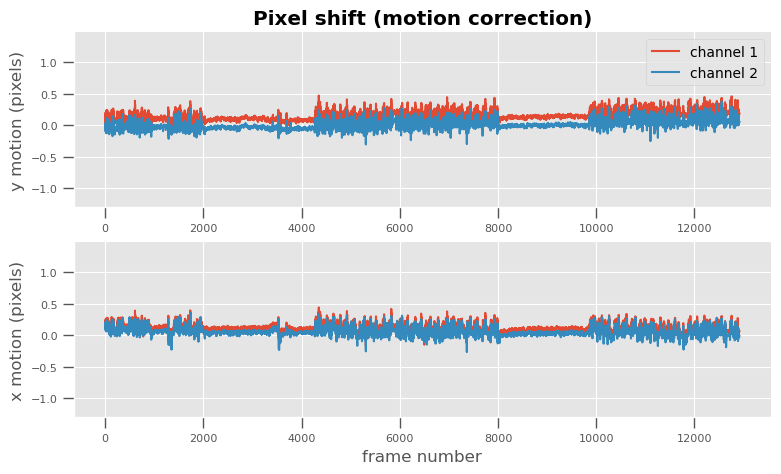

In [23]:
import pylab as plt
plt.matplotlib.style.use('ggplot')

%matplotlib inline

# localdisk = '/mnt/dual/temp_folder/CSP23_20200226' # this should be an SSD or a fast drive

shifts = np.load(pjoin(localdisk,'motion_correction_shifts.npy'))

plot_summary_motion_correction(shifts,localdisk);

In [25]:
save_video_from_array(dat, f"{scan_idx}_motion_corrected",localdisk,2)

Videos saved successfully.


# Match Dorsal Cortex to the Allen Atlas

# Masked decomposition

In [6]:
from wfield import atlas_from_landmarks_file
from wfield import *

In [7]:
folder = localdisk
SVT = np.load(pjoin(folder,'SVT.npy'))
SVT_470 = SVT[:,::2]
SVT_405 = SVT[:,1::2]
SVT_corr = np.load(pjoin(folder,'SVTcorr.npy'))
U = np.load(pjoin(folder,'U.npy'))
T = np.load(pjoin(folder,'T.npy'))


In [12]:
# filter and interpolate
t = np.arange(SVT_470.shape[1]*2) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2],SVT_405,axis=1,
                   fill_value='extrapolate')(t[0::2])
freq_highpass = 0.1
fs = 33.
SVT_470 = highpass(SVT_470,w = freq_highpass, fs = fs).astype(np.float32)
SVT_405 = highpass(SVT_405,w = freq_highpass, fs = fs).astype(np.float32)

ref_folder = '/home/aeltona/wfield/references'
# Apply the transform, prepare for plotting
lmarks = load_allen_landmarks(pjoin(ref_folder,'dorsal_cortex_landmarks.json'))
ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')
bout = brain_outline/lmarks['resolution'] + np.array(lmarks['bregma_offset'])

mask = contour_to_mask(*bout.T,dims = U.shape[:-1])

if 'dims' in dir():
    U = U.reshape(dims)

# warp and mask U, first make boarders zero
from wfield.imutils import mask_to_3d
U[:,0,:] = 0
U[0,:,:] = 0
U[-1,:,:] = 0
U[:,-1,:] = 0
U = np.stack(runpar(im_apply_transform,
                    U.transpose([2,0,1]),
                    M = lmarks['transform']))
U[mask_to_3d(mask,U.shape)==0] = np.nan
U = U.transpose([1,2,0])

KeyError: 'transform'

In [13]:
lmarks

{'bregma_offset': [320, 270],
 'landmarks':       x     y       name    color
 0 -1.95 -3.45    OB_left  #fc9d03
 1  0.00 -3.45  OB_center  #0367fc
 2  1.95 -3.45   OB_right  #fc9d03
 3  0.00  3.20   RSP_base  #fc4103,
 'landmarks_im':             x           y       name    color
 0  219.484536   92.164948    OB_left  #fc9d03
 1  320.000000   92.164948  OB_center  #0367fc
 2  420.515464   92.164948   OB_right  #fc9d03
 3  320.000000  434.948454   RSP_base  #fc4103,
 'resolution': 0.0194}

# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 

The first example subtracts the average from each frame (i.e. the array in `frames_average` with 3 dimensions (ch,w,h)). The average can be the mean of all frames or only those in the baseline period of the experiment.


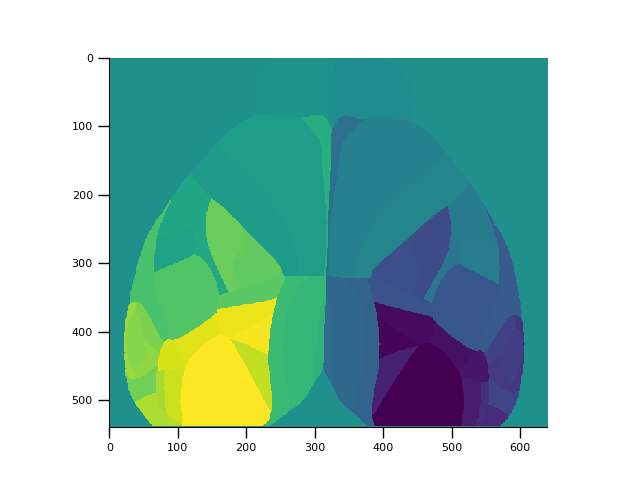

In [5]:
import numpy as np
import pylab as plt


from wfield import atlas_from_landmarks_file
from wfield import *

lmarks = glob(pjoin(localdisk,'ccf_transform.json'))
if len(lmarks):
    atlas, areanames, brain_mask = atlas_from_landmarks_file(lmarks[0],do_transform=True)

%matplotlib widget
plt.imshow(atlas)

In [13]:
# dat = load_stack(localdisk)

dat = mmap_dat(dat_path)
print(dat.shape)
n_frames = dat.shape[0]
print(n_frames)

dat = mmap_dat(dat_path, mode='r+', nframes=n_frames, shape=(2, h, w))

frames_average = np.load(pjoin(localdisk,'frames_average.npy'))

mask  = get_std_mask(dat[:,0],threshold=60)
U,SVT = approximate_svd(dat, frames_average, mask = mask, k = 200)

(8619, 600, 600, 2)
8619


Computing SVT from the raw data: 100%|██████████| 18/18 [00:56<00:00,  3.16s/it]


{'fig': <Figure size 640x480 with 1 Axes>,
 'ax': <Axes: >,
 'im': <matplotlib.image.AxesImage at 0x7f06035f2150>,
 'update': <function wfield.viz.nb_play_movie.<locals>.update_image(change)>}

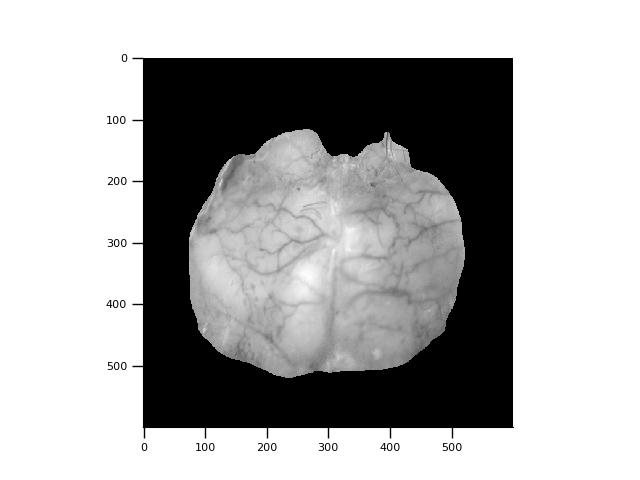

In [14]:
import pylab as plt
from wfield import nb_play_movie
from wfield import SVDStack
%matplotlib widget
stack = SVDStack(U,SVT)
plt.figure()
nb_play_movie(stack,cmap='gray')

In [24]:
# dat = mmap_dat(dat_path)
dat = mmap_dat(dat_path, mode='r+', nframes=n_frames, shape=(2, h, w))

try:
    frames_average = np.load(pjoin(localdisk,'frames_average.npy')) # or see below (can also be computed using the baseline)
    print("Frames Average found!")
except Exception as e:
    print("Error:", e)
    print("Averaging frames...")
    chunkidx = chunk_indices(len(dat),chunksize=512)
    frame_averages = []
    for on,off in tqdm(chunkidx):
       frame_averages.append(dat[on:off].mean(axis=0))
    frames_average = np.stack(frame_averages).mean(axis = 0)
    np.save(pjoin(localdisk,'frames_average.npy'),frames_average)
    print(f"frames_average.npy saved in {localdisk}")


Frames Average found!


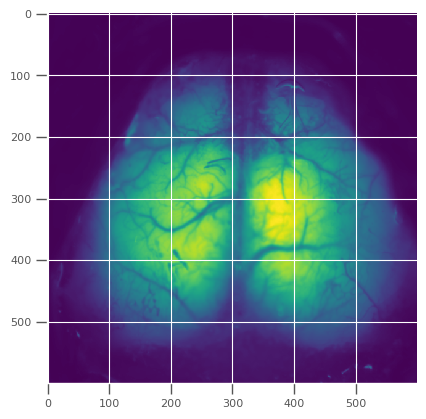

In [26]:
# frames_average.shape
plt.imshow(frames_average[1,:,:]);

In [29]:
# Reshape the array to combine frame and channel dimensions
movie_reshaped = np.transpose(dat, (0, 2, 3, 1))  # [n_frames, height, width, n_channels]

# Calculate variance for each channel across frames
channel_variances = np.var(movie_reshaped, axis=0)  # [height, width, n_channels]

# Get the maximum variance across all channels
max_variance = np.max(channel_variances)

# Plot the variance for each channel separately
num_channels = channel_variances.shape[2]


In [30]:
max_variance

13038694.804228742

In [15]:
# Plot the variance for each channel along with histograms
num_channels = channel_variances.shape[2]
fig, axes = plt.subplots(2, num_channels, figsize=(5*num_channels, 10))

for i in range(num_channels):
    # Plot variance heatmap
    ax_heatmap = axes[0, i] if num_channels > 1 else axes[0]
    im = ax_heatmap.imshow(channel_variances[:, :, i], cmap='hot', interpolation='nearest', vmin=0, vmax=max_variance)
    ax_heatmap.set_title(f'Channel {i+1} Variance')
    ax_heatmap.set_xlabel('Width')
    ax_heatmap.set_ylabel('Height')
    ax_heatmap.axis('off')
    fig.colorbar(im, ax=ax_heatmap, orientation='vertical', label='Variance (Normalized)')

    # Plot histogram
    ax_hist = axes[1, i] if num_channels > 1 else axes[1]
    ax_hist.hist(channel_variances[:, :, i].ravel(), bins=50, color='blue', alpha=0.7)
    ax_hist.set_title(f'Channel {i+1} Variance Histogram')
    ax_hist.set_xlabel('Variance')
    ax_hist.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

NameError: name 'channel_variances' is not defined

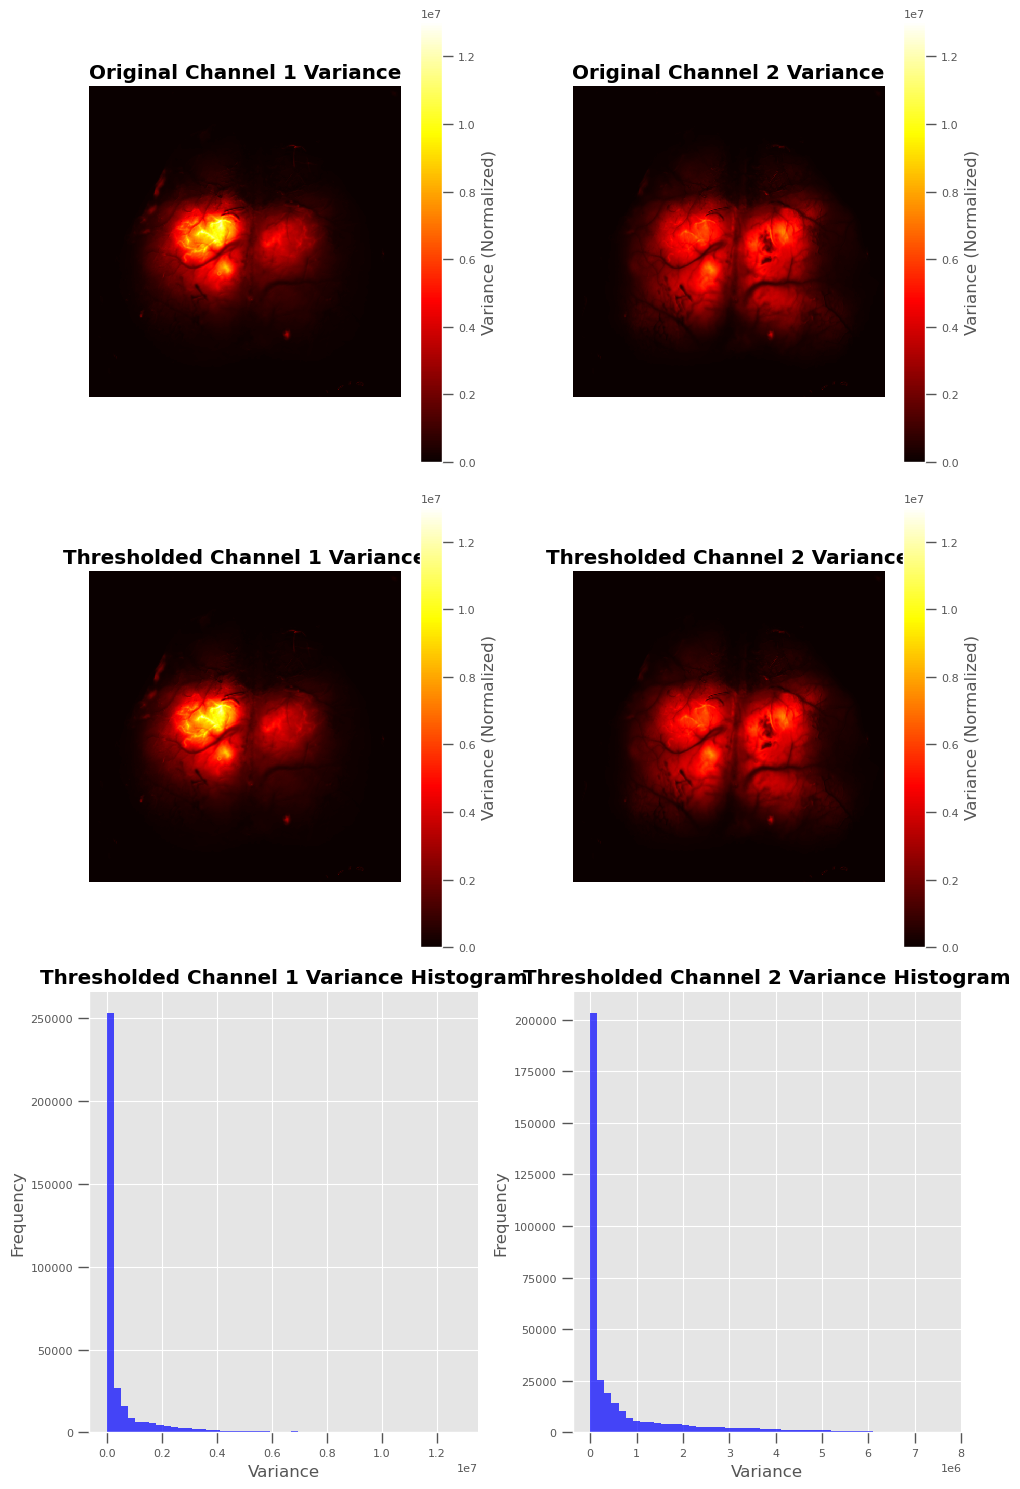

In [43]:
# Define the threshold for variance
threshold = 13038694  # Change this to your desired threshold value

max_variance = 13038694.804228742
# Plot the variance for each channel along with histograms
num_channels = channel_variances.shape[2]
fig, axes = plt.subplots(3, num_channels, figsize=(5*num_channels, 15))

for i in range(num_channels):
    # Plot original variance heatmap
    ax_original = axes[0, i] if num_channels > 1 else axes[0]
    im_original = ax_original.imshow(channel_variances[:, :, i], cmap='hot', interpolation='nearest', vmin=0, vmax=max_variance)
    ax_original.set_title(f'Original Channel {i+1} Variance')
    ax_original.set_xlabel('Width')
    ax_original.set_ylabel('Height')
    ax_original.axis('off')
    fig.colorbar(im_original, ax=ax_original, orientation='vertical', label='Variance (Normalized)')
    
    # Apply threshold
    channel_variances_thresholded = channel_variances[:, :, i].copy()
    channel_variances_thresholded[channel_variances_thresholded > threshold] = 0
    
    # Plot thresholded variance heatmap
    ax_thresholded = axes[1, i] if num_channels > 1 else axes[1]
    im_thresholded = ax_thresholded.imshow(channel_variances_thresholded, cmap='hot', interpolation='nearest', vmin=0, vmax=max_variance)
    ax_thresholded.set_title(f'Thresholded Channel {i+1} Variance')
    ax_thresholded.set_xlabel('Width')
    ax_thresholded.set_ylabel('Height')
    ax_thresholded.axis('off')
    fig.colorbar(im_thresholded, ax=ax_thresholded, orientation='vertical', label='Variance (Normalized)')

    # Plot histogram
    ax_hist = axes[2, i] if num_channels > 1 else axes[2]
    ax_hist.hist(channel_variances_thresholded.ravel(), bins=50, color='blue', alpha=0.7)
    ax_hist.set_title(f'Thresholded Channel {i+1} Variance Histogram')
    ax_hist.set_xlabel('Variance')
    ax_hist.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [51]:
from skimage.draw import polygon

# Function to create a triangle mask
def create_triangle_mask(height, width, apex, angle, side_length):
    mask = np.zeros((height, width), dtype=np.uint8)
    row, col = polygon([apex[0], apex[0] + side_length * np.sin(angle), apex[0]], 
                       [apex[1], apex[1], apex[1] + side_length * np.cos(angle)], 
                       mask.shape)
    mask[row, col] = 1
    return mask

# Function to apply triangle masks to corners
def apply_corner_masks(image, corner_masks):
    masked_image = image.copy()
    for mask in corner_masks:
        masked_image *= (1 - mask)
    return masked_image

In [62]:
-3*np.pi/4

-2.356194490192345

In [77]:
num_channels

2

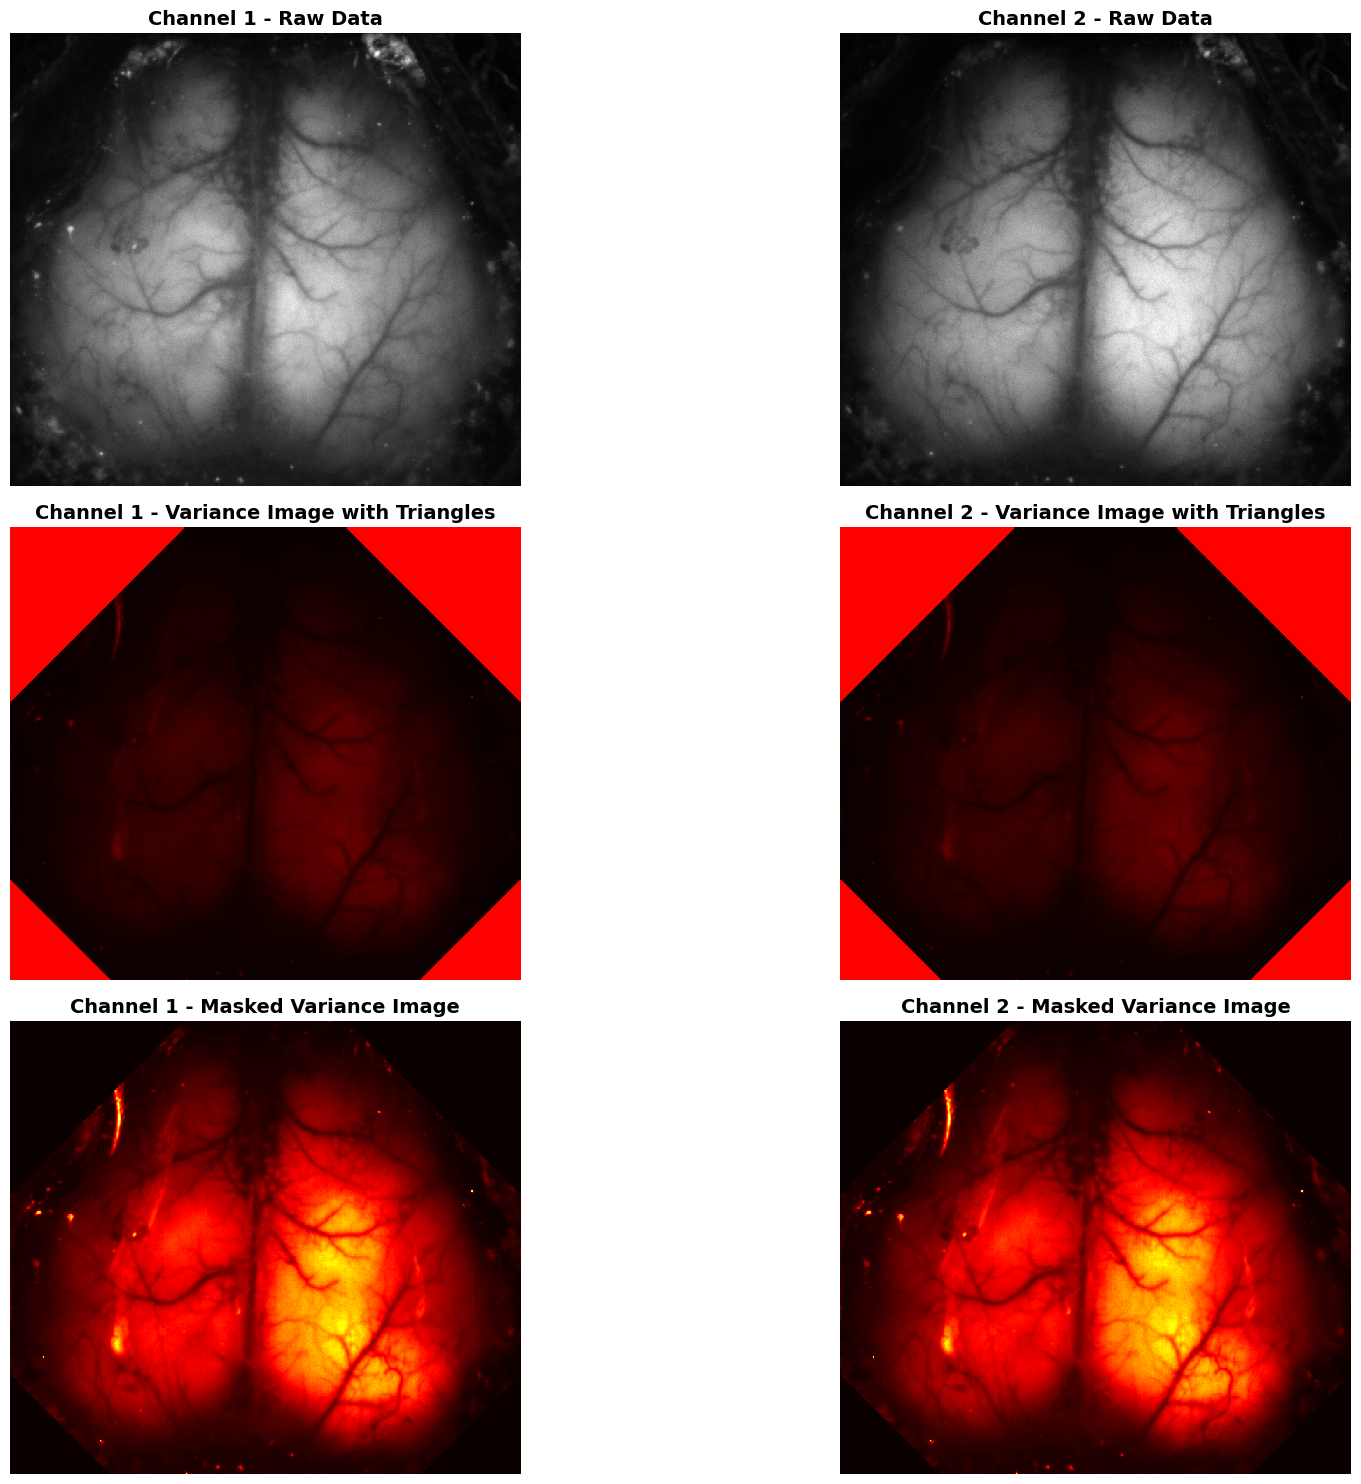

In [75]:
# Calculate variance for each channel across frames
channel_variances = np.var(dat, axis=0)  # [n_channels, height, width]

# Create subplots for each channel
num_channels = channel_variances.shape[0]
fig, axes = plt.subplots(3, num_channels, figsize=(10*num_channels, 15))

corner_params = [
    {"apex": (0, 0), "angle": np.pi/4, "side_length": 350},  # Top-left corner
    {"apex": (channel_variances.shape[1] - 1, 0), "angle": -np.pi/4, "side_length":200},  # Bottom-left corner
    {"apex": (0, channel_variances.shape[2] - 1), "angle": 3*np.pi/4, "side_length": 350},  # Top-right corner
    {"apex": (channel_variances.shape[1] - 1, channel_variances.shape[2] - 1), "angle": -3*np.pi/4, "side_length": 200}  # Bottom-right corner
]

# Plot raw data for each channel
for i in range(num_channels):
    axes[0, i].imshow(dat[0, i], cmap='gray')
    axes[0, i].set_title(f'Channel {i+1} - Raw Data')
    axes[0, i].axis('off')

# Plot triangles drawn on top of variance image for each channel
for i in range(num_channels):
    ax = axes[1, i]
    ax.imshow(np.max(channel_variances, axis=0), cmap='hot', interpolation='nearest')
    ax.set_title(f'Channel {i+1} - Variance Image with Triangles')
    for params in corner_params:
        row, col = polygon([params["apex"][0], params["apex"][0] + params["side_length"] * np.sin(params["angle"]), params["apex"][0]], 
                           [params["apex"][1], params["apex"][1], params["apex"][1] + params["side_length"] * np.cos(params["angle"])], 
                           channel_variances.shape[1:])
        ax.plot(col, row, color='red')
    ax.axis('off')

# Plot masked variance image after removing pixels within triangles for each channel
for i in range(num_channels):
    corner_masks = [create_triangle_mask(channel_variances.shape[1], channel_variances.shape[2], **params) for params in corner_params]
    masked_variances = apply_corner_masks(np.max(channel_variances, axis=0), corner_masks)
    axes[2, i].imshow(masked_variances, cmap='hot', interpolation='nearest')
    axes[2, i].set_title(f'Channel {i+1} - Masked Variance Image')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [116]:
masked_variances.shape

(647, 730)

In [16]:
# U,SVT = approximate_svd(dat, frames_average)
np.save(pjoin(localdisk,'U.npy'),U)
np.save(pjoin(localdisk,'SVT.npy'),SVT)

# Hemodynamics Correction

In [17]:
U = np.load(pjoin(localdisk,'U.npy'))
SVT = np.load(pjoin(localdisk,'SVT.npy'))

# SVT.shape

In [18]:
SVTcorr = np.load(pjoin(localdisk,'SVTcorr.npy'))

In [96]:
SVTcorr.shape

(200, 3047)

In [106]:
def plot_components(data, start, end):
    num_components = end - start + 1
    plt.figure(figsize=(10, 2 * num_components))
    for i in range(start, end + 1):
        plt.subplot(num_components, 1, i - start + 1)
        plt.plot(data[i, :])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

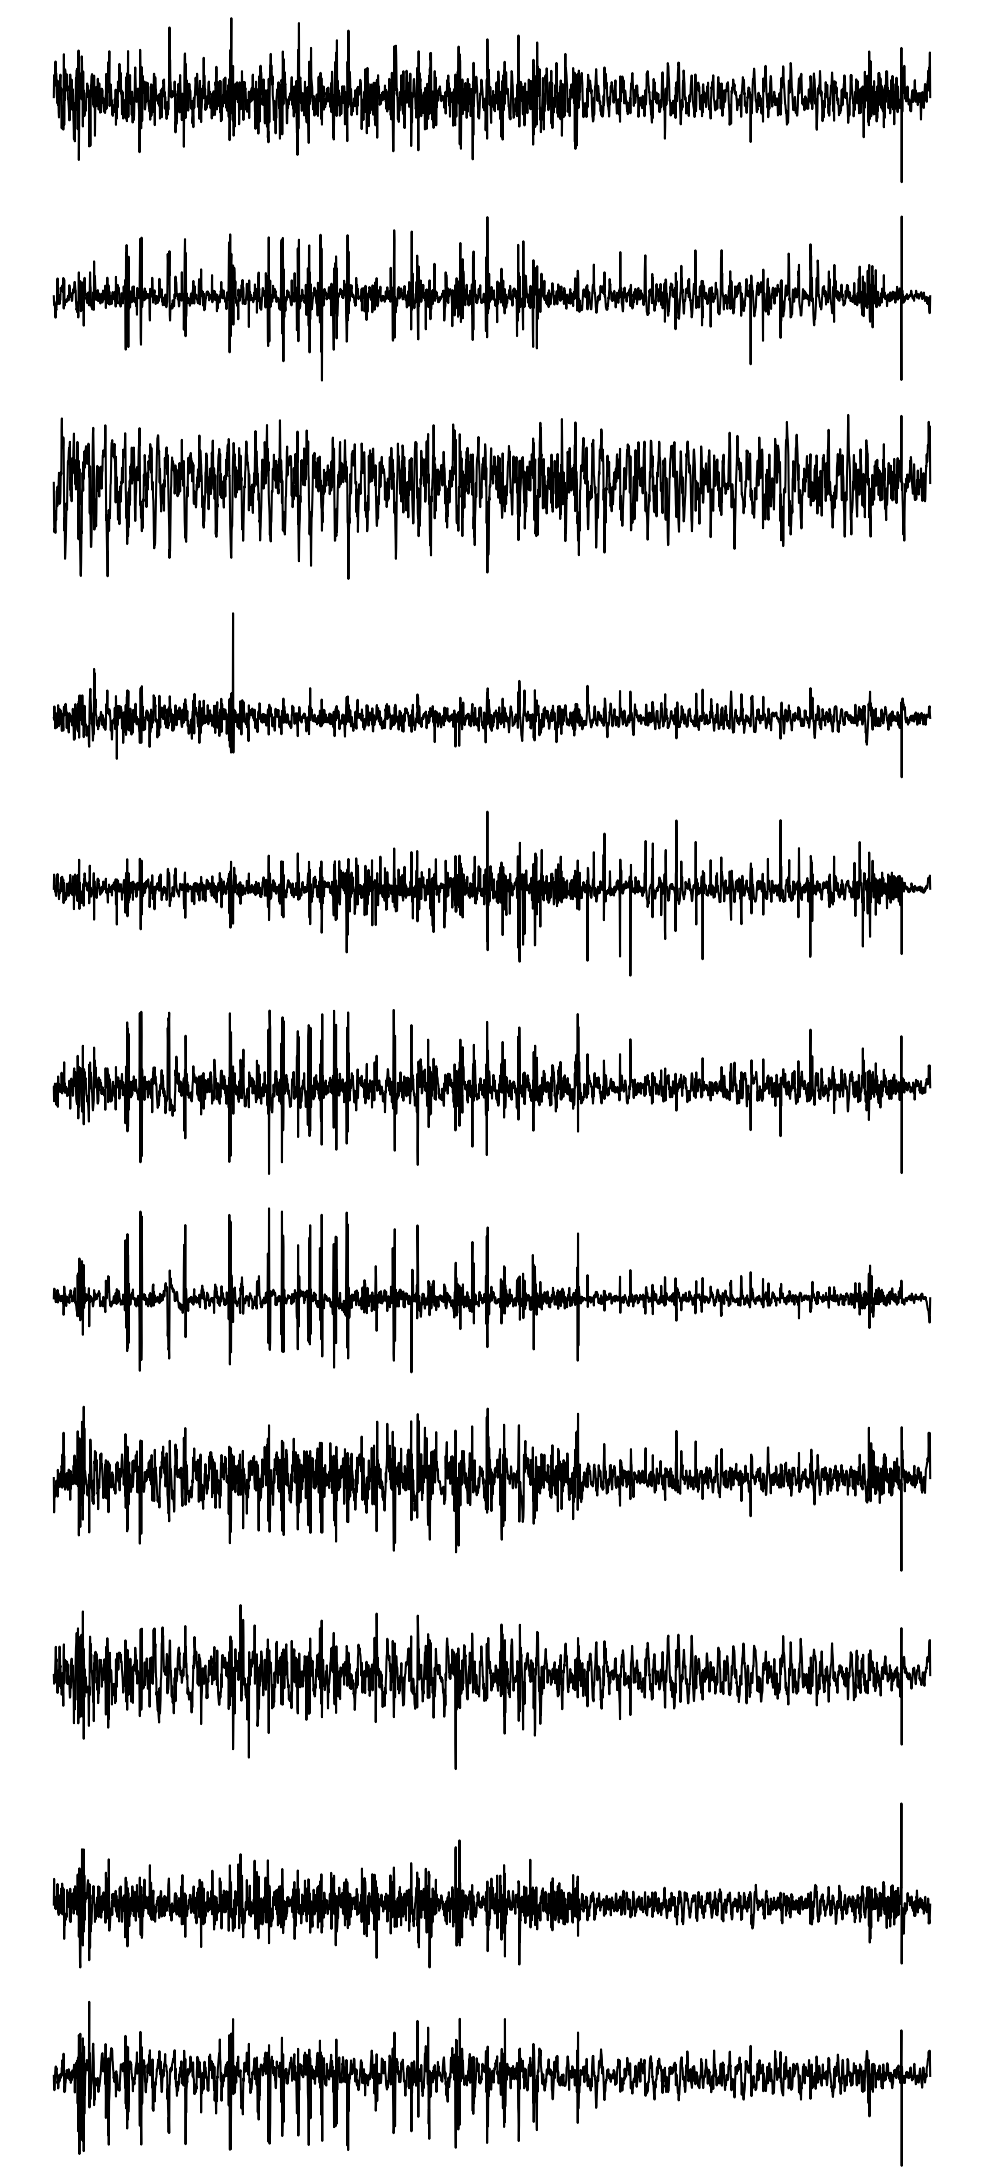

In [107]:
# Example usage: plot components 3 to 7
plot_components(SVTcorr, 10,20)

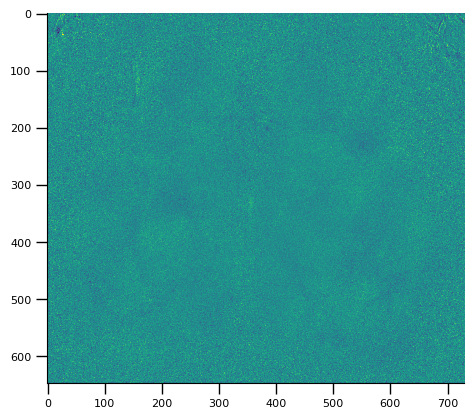

In [115]:
plt.imshow(U[:,:,80]);

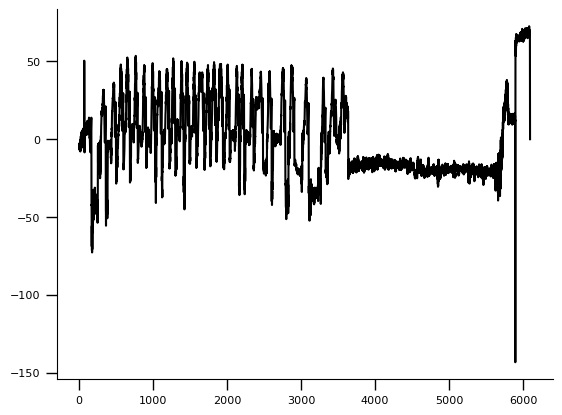

In [81]:
plt.plot(SVT[0,:])

In [79]:
SVT.shape

(200, 6094)

In [19]:
fs = 5

output_folder = localdisk
frame_rate = 10.

tstart = time.time()

SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2],SVT[:,1::2],axis=1,
                    fill_value='extrapolate')(t[0::2])
SVTcorr, rcoeffs, T = hemodynamic_correction(U, 
                                             SVT_470, 
                                             SVT_405, 
                                             fs=fs,
                                             freq_lowpass=2)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))

np.save(pjoin(localdisk,'rcoeffs.npy'),rcoeffs)
np.save(pjoin(localdisk,'T.npy'),T)
np.save(pjoin(localdisk,'SVTcorr.npy'),SVTcorr)



Done hemodynamic correction in 55.02129912376404 s 


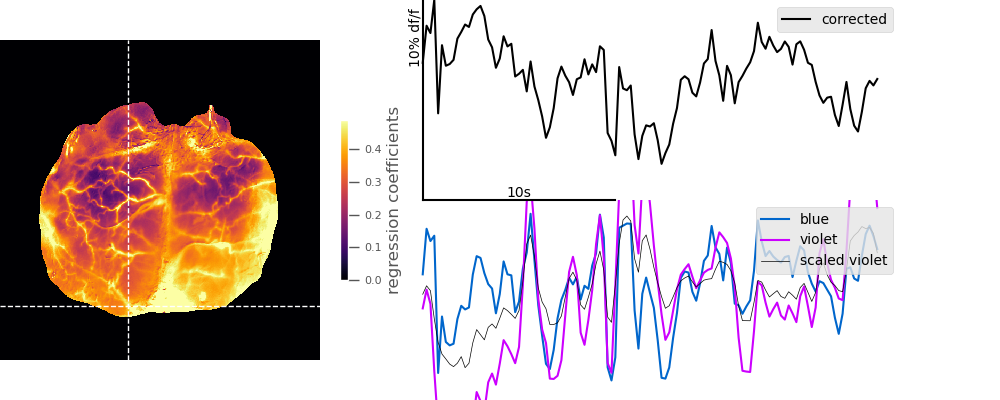

In [20]:
try: # don't crash while plotting
    import pylab as plt
    plt.matplotlib.style.use('ggplot')
    from wfield import  plot_summary_hemodynamics_dual_colors
    plot_summary_hemodynamics_dual_colors(rcoeffs,
                                            SVT_470,
                                            SVT_405,
                                            U,
                                            T,
                                            frame_rate=frame_rate,
                                            duration = 12,
                                            outputdir = output_folder);
except Exception as err:
    print('There was an issue plotting.')
    print(err)

# Reading Aux file

In [5]:
import h5py


In [18]:
h5_path = glob(pjoin(localdisk,'*.h5'))[0]
h5_path

'/datajoint-data/data/aeltona/Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG/scan9FN2BCOS_Oddball_Oddball_AA_ROS-1706_0003.h5'

In [21]:

# Open the HDF5 file
with h5py.File(h5_path, 'r') as f:
    # Access specific group
    print(f.keys())
    sweep_data = f['sweep_0003']
    header = f['header']
    # List all keys within the group
    print("Keys in sweep_0001: %s" % sweep_data.keys())
    print("Keys in header: %s" % header.keys())
    
    
    AIChannelNames = header['AIChannelNames'][:]
    AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
    SampleRate = header['AcquisitionSampleRate'][:]
    analogData = sweep_data['analogScans'][:]
    # # Check if 'data' exists within the group
    # if 'analogScans' in sweep_data:
    #     data = sweep_data['analogScans'][:]  # accessing array dataset
    #     print("Data from sweep_0001:", data)
    # else:
    #     print("Dataset 'data' does not exist in sweep_0001.")

<KeysViewHDF5 ['header', 'sweep_0003']>
Keys in sweep_0001: <KeysViewHDF5 ['analogScans', 'digitalScans', 'timestamp']>
Keys in header: <KeysViewHDF5 ['AIChannelDeviceNames', 'AIChannelNames', 'AIChannelScales', 'AIChannelTerminalIDs', 'AIChannelTerminalNames', 'AIChannelUnits', 'AIScalingCoefficients', 'AITerminalIDsOnEachDevice', 'AOChannelDeviceNames', 'AOChannelNames', 'AOChannelScales', 'AOChannelTerminalIDs', 'AOChannelTerminalNames', 'AOChannelUnits', 'AbsoluteProtocolFileName', 'AbsoluteUserSettingsFileName', 'AcquisitionSampleRate', 'AcquisitionTriggerIndex', 'AllChannelNames', 'AllDeviceNames', 'AreColorsNormal', 'AreSoftpanelsEnabled', 'AreSweepsContinuous', 'AreSweepsFiniteDuration', 'AreYLimitsLockedTightToDataForAIChannel', 'CacheInputChannelIndexFromInputChannelIndex', 'ChannelIndexFromPlotIndex', 'ChannelIndexWithinTypeFromPlotIndex', 'ChannelsFigurePosition', 'ClockAtRunStart', 'CounterTriggerCount', 'CurrentProfileName', 'CurrentRunAbsoluteFileName', 'DIChannelDeviceN

In [12]:
import pandas as pd

In [13]:
SampleRate

array([[20000.]])

In [22]:
# Convert analogData to DataFrame
df = pd.DataFrame(analogData.T, columns=AIChannelNames)

# Print DataFrame
# print(df)

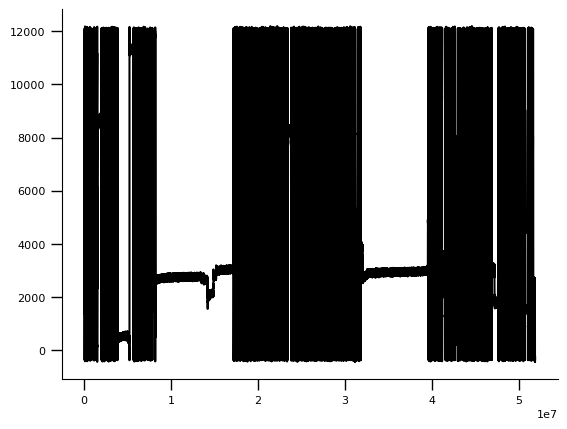

In [23]:
plt.plot(df['Rotary Encoder']);

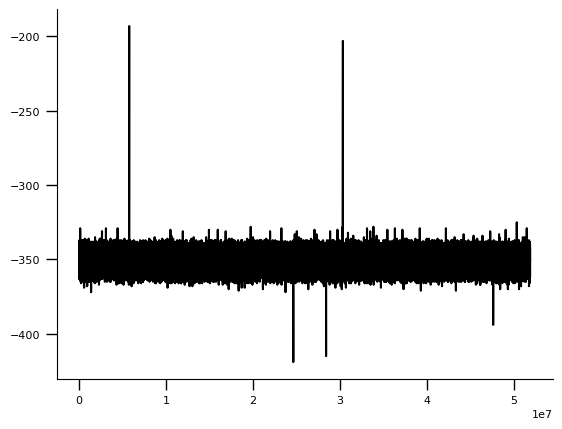

In [24]:
plt.plot(df['SoftCode']);

# LOCANMF

In [4]:
import matplotlib.pyplot as plt
# import cv2
import os
import numpy as np
import re
import shutil

In [13]:
U = np.load(os.path.join(localdisk,'U.npy'))
SVT = np.load(os.path.join(localdisk,'SVTcorr.npy'))
# mask = np.load(pjoin(localdisk,'mask.npy'))
mask = im_apply_transform(mask.astype('int8'), M = lmarks['transform'])
lmarksfile = glob(os.path.join(localdisk,'ccf_transform.json'))
lmarks = load_allen_landmarks(lmarksfile[0])

NameError: name 'im_apply_transform' is not defined

In [24]:
def get_U_atlas(U,M):
    U = U.copy()
    U[:,0,:] = 1e-10
    U[0,:,:] = 1e-10
    U[-1,:,:] = 1e-10
    U[:,-1,:] = 1e-10

    # transpose U
    return np.stack(runpar(im_apply_transform, U.transpose([2,0,1]),
                           M = M)).transpose([1,2,0]).astype(np.float32)

In [26]:
Uatlas = get_U_atlas(U,M = lmarks['transform'])
# load the mask 
mask = im_apply_transform(mask.astype('int8'), M = lmarks['transform'])

# load the atlas
atlas, areanames, brain_mask = atlas_from_landmarks_file(lmarksfile[0],dims=[600,600],do_transform=False)

mask = (mask>0) & (atlas != 0)  
atlas[mask==0] = 0   # this will discard the masked areas from the atlas


In [28]:
lmarks

{'bregma_offset': [300, 300],
 'landmarks':       x     y       name    color
 0 -1.95 -3.45    OB_left  #fc9d03
 1  0.00 -3.45  OB_center  #0367fc
 2  1.95 -3.45   OB_right  #fc9d03
 3  0.00  3.20   RSP_base  #fc4103,
 'landmarks_im':             x           y       name    color
 0  199.484536  122.164948    OB_left  #fc9d03
 1  300.000000  122.164948  OB_center  #0367fc
 2  400.515464  122.164948   OB_right  #fc9d03
 3  300.000000  464.948454   RSP_base  #fc4103,
 'landmarks_match':             x           y       name    color
 0  224.157433   88.036508    OB_left  #fc9d03
 1  322.429907   89.137426  OB_center  #0367fc
 2  431.917333   89.137426   OB_right  #fc9d03
 3  310.093458  467.150288   RSP_base  #fc4103,
 'resolution': 0.0194,
 'transform': <SimilarityTransform(matrix=
     [[ 1.09071864e+00, -3.91692046e-02,  3.07568471e+00],
      [ 3.91692046e-02,  1.09071864e+00, -5.51030250e+01],
      [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x7f0608e27c50>,
 'transfor

In [29]:
def im_apply_affine(im,transform):
    W,H = im.shape
    M = transform.params[:2,:]
    return cv2.warpAffine(im, M, (H, W),cv2.WARP_INVERSE_MAP)
def get_U_atlas(U,M):
    U = U.copy()
    U[:,0,:] = 1e-10
    U[0,:,:] = 1e-10
    U[-1,:,:] = 1e-10
    U[:,-1,:] = 1e-10

    # transpose U
    return np.stack(runpar(im_apply_affine, U.transpose([2,0,1]),
                           transform = M)).transpose([1,2,0]).astype(np.float32)
    
# Uatlas = get_U_atlas(U,M = lmarks['transform_inverse'])
Uatlas = get_U_atlas(U,M = lmarks['transform'])

{'fig': <Figure size 640x480 with 1 Axes>,
 'ax': <Axes: >,
 'im': <matplotlib.image.AxesImage at 0x7f060871a150>,
 'update': <function wfield.viz.nb_play_movie.<locals>.update_image(change)>}

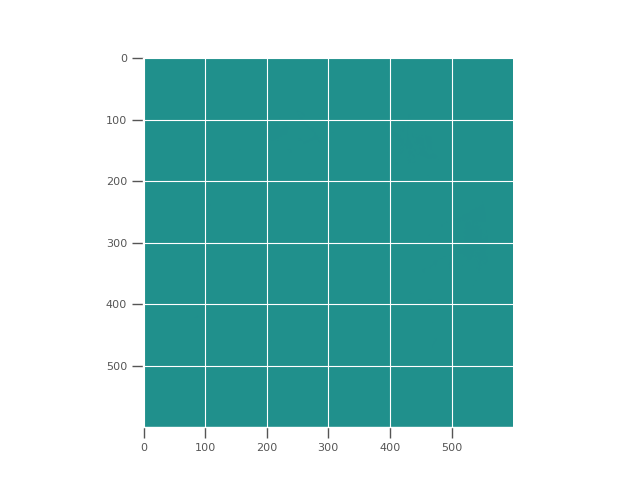

In [30]:
# play the stack
plt.figure()
nb_play_movie(SVDStack(Uatlas,SVT),clim = [-0.1,0.1])

In [14]:
# Run semiNMF, seed region is the entire brain mask
Asemi,Csemi,regions_semi = compute_locaNMF(Uatlas,
                                           SVT,
                                           mask.astype('int8'), # this is the seed, in this case the whole dorsal cortex
                                           mask,
                                           minrank = 1, 
                                           maxrank = 200, 
                                           min_pixels = 100,
                                           loc_thresh = 1, 
                                           r2_thresh = 0.99)

# # Run locaNMF, seed region is the CCF atlas
A,C,regions = compute_locaNMF(Uatlas,
                              SVT,
                              atlas, # seeds the atlas
                              mask,
                              minrank = 1, 
                              maxrank = 20, 
                              min_pixels = 100,
                              loc_thresh = 60, 
                              r2_thresh = 0.99)


NameError: name 'compute_locaNMF' is not defined